# Project: Build an XGBoost model

## Introduction

In this project, I build a XGBoost classification model, using the airline dataset that I previously used in building the decision tree and random forest models, and then compare the performance of the three models. The ultimate goal is to decide which model is best. 

Lastly, I explore the features importance that most contribute to customer satisfaction, as revealed by my XGBoost model.

## Step 1: Imports

### Import packages

In [7]:
# Import relevant libraries and modules.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, \
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

### Load the dataset

In [8]:
# Import data. Tell Pandas to ignore and drop malformed rows from the resulting DataFrame, instead of raising an error.

airline_data = pd.read_csv('Invistico_Airline.csv', error_bad_lines=False)

### Display the data

I examine the first 10 rows of data to familiarize myself with the dataset.

In [9]:
# Display the first ten rows of data.

airline_data.head(10)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,...,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,...,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,...,2,2,2,4,5,3,4,2,30,26.0


### Display the data type for each column

Next, observe the types of data present within this dataset.

In [10]:
# Display the data type for each column in my DataFrame.

airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj

**Commentary:**

- The target (or predicted) variable for passenger satisfaction is `satisfaction`.
- Based on my running a decision tree model during an earlier lab that returned inflight entertainment and seat comfort as the most valuable variables in predicting satisfaction, I'm expecting that these same variables will emerge as having high importance in the XGBoost model.

In [11]:
# Shape of dataframe
airline_data.shape

(129880, 22)

## Step 2: Model preparation

**Commentary:**

The metrics most suited for evaluating this type of model are:
- Accuracy, precision, recall, and the F1 score, as this is a binary classification problem.
- Additionally, since it is important to achieve the maximimun true positives while minimizing the false positives, the  AUC (Receiver Operating Characteristic curve) score will be helpful.

### Data preparation for modeling

To prepare this DataFrame for modeling, first convert all non-numerical variables (`object` data types) into a numerical format.

In [12]:
# Convert the object predictor variables to numerical dummies.

airline_data_dummies = pd.get_dummies(airline_data, drop_first=True)
airline_data_dummies.tail(10)

# Note: By droping the first column, it ensures only one "target" column, which is the column
# that assigns a positive (i.e., "satisfied") outcome as 1.

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,...,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction_satisfied,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
129870,70,1674,5,4,5,1,5,5,5,5,...,5,4,5,54,46.0,1,1,1,1,0
129871,35,3287,5,4,5,3,2,5,2,2,...,4,3,2,9,0.0,1,1,1,1,0
129872,69,2240,5,4,5,3,4,5,4,4,...,3,4,4,4,0.0,1,1,1,1,0
129873,63,1942,5,5,4,4,3,4,3,3,...,3,5,3,7,NaN,1,1,1,1,0
129874,11,2752,5,5,5,2,2,5,2,2,...,5,4,2,5,0.0,1,1,1,1,0
129875,29,1731,5,5,5,3,2,5,2,2,...,4,4,2,0,0.0,1,1,1,1,0
129876,63,2087,2,3,2,4,2,1,1,3,...,1,2,1,174,172.0,0,1,1,0,0
129877,69,2320,3,0,3,3,3,2,2,4,...,2,3,2,155,163.0,0,1,1,1,0
129878,66,2450,3,2,3,2,3,2,2,3,...,2,1,2,193,205.0,0,1,1,1,0
129879,38,4307,3,4,3,3,3,3,3,4,...,3,3,3,185,186.0,0,1,1,1,0


### Isolate my target and predictor variables
Separately define the target variable (`satisfaction`) and the features.

In [13]:
# Define the y (target) variable. Satisfied is coded as 1
y = airline_data_dummies['satisfaction_satisfied']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: satisfaction_satisfied, dtype: uint8

In [14]:
# Define the X (predictor) variables.
X = airline_data_dummies.copy()
X= X.drop('satisfaction_satisfied', axis=1)
X.head()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,...,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,65,265,0,0,0,2,2,4,2,3,...,3,5,3,2,0,0.0,0,1,1,0
1,47,2464,0,0,0,3,0,2,2,3,...,4,2,3,2,310,305.0,0,1,0,0
2,15,2138,0,0,0,3,2,0,2,2,...,4,4,4,2,0,0.0,0,1,1,0
3,60,623,0,0,0,3,3,4,3,1,...,1,4,1,3,0,0.0,0,1,1,0
4,70,354,0,0,0,3,4,3,4,2,...,2,4,2,5,0,0.0,0,1,1,0


### Divide my data 

Divide my data into a training set (75% of the data) and test set (25% of the data). This is an important step in the process, as it allows me to reserve a part of the data that the model has not used as test data to assess how well the model generalizes (or performs) on new data.

In [15]:
y.value_counts(normalize=True) * 100

1    54.73283
0    45.26717
Name: satisfaction_satisfied, dtype: float64

In [16]:
# Perform the split operation on my data.
# Class balance is reasonable, so no need to stratify `y`. Moreover, XGBoost has built-in mechanisms to handle
# imbalanced datasets.
# Assign the outputs as follows: X_train, X_test, y_train, y_test.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 0)

## Step 3: Model building

### "Instantiate" my XGBClassifer

Before I fit my model for the airline dataset, I'll create the XGB Classifier model and define its objective. I'll then use this model to fit and score different hyperparameters during the GridSearch cross-validation process.

In [17]:
# Define xgb to be my XGBClassifier.

xgb = XGBClassifier(objective='binary:logistic', random_state=0)

### Define the parameters for hyperparameter tuning

To identify suitable parameters for my `xgboost` model, I define the parameters for hyperparameter tuning. Specifically, I consider tuning `max_depth`, `min_child_weight`, `learning_rate`, `n_estimators`, `subsample`, and/or `colsample_bytree`.

I decide to use a more limited range for each hyperparameter to allow for timely iteration and model training. Note: using a single possible value for each of the six hyperparameters listed above will take approximately one minute to run on this platform.

```
{
    'max_depth': [4],
    'min_child_weight': [3],
    'learning_rate': [0.1],
    'n_estimators': [5],
    'subsample': [0.7],
    'colsample_bytree': [0.7]
}
```

So, by adding just one new option, such as changing `max_depth: [4]` to `max_depth: [3, 6]`, and keeping everything else the same, I can expect the run time to approximately double. And if I use two possibilities for each hyperparameter, the run time would extend to ~1 hour. 
         

In [18]:
# Define parameters for tuning as `cv_params`.

cv_params = {
    'max_depth': [2,4],
    'min_child_weight': [3,6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [20, 50],
    'subsample': [0.7],
    'colsample_bytree': [0.7]
}

**Commentary:** 

Adding more estimators to my GridSearch will initially improve the model's performance. However, increasing the number of estimators will also considerably increase the time spent during the GridSearch process, and there will be diminishing returns as the number of estimators continues to increase.

### Define how the models will be evaluated

I will utilize a suite of metrics to evaluate my model for hyperparameter tuning.

In [19]:
# Define my criteria as `scoring`. These are shortcuts that sklearn uses to tell
# the underlying algorithm which metrics to optimize on the validation folds to find the "best" model.

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

### Construct the GridSearch cross-validation 

I will construct the GridSearch cross-validation using the model, parameters, and scoring metrics I defined. Additionally, I will define the number of folds and specify *which metric* from above will guide the refit strategy.

In [20]:
# Construct the GridSearch.

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

# refit = 'f1' simultaneously balances false positives and false negatives.
# The number of folds choosen balances the time spent on validation.

### Fit the GridSearch model to my training data

Narrowing the parameter ranges and reducing the number of estimators will reduce the time for the hyperparameter tuning.

In [21]:
%%time
# fit the GridSearch model to training data

#xgb_cv.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


### Save model for reference using `pickle`

In [22]:
# Use `pickle` to save the trained model.

path = '/home/jovyan/work/'

#with open(path + 'xgb_cv_model.pkl', 'wb') as to_write: # Provide a name for the pickle file
    #pkl.dump(xgb_cv, to_write) 

In [23]:
# Open pickled model

with open(path+'xgb_cv_model.pkl', 'rb') as to_read:
    xgb_cv = pkl.load(to_read)

In [24]:
# Return best GridSearchCV parameters
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 6,
 'n_estimators': 50,
 'subsample': 0.7}

In [25]:
# Return best GridSearchCV estimators
xgb_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

## Step 4: Results and evaluation

### Formulate predictions on my test set

To evaluate the predictions yielded from my model, I will leverage a series of metrics and evaluation techniques from scikit-learn by examining the actual observed values in the test set relative to my model's prediction.

First, I will use my trained model to formulate predictions on my test set.

In [26]:
# Apply my model to predict on the test data, and call this output "y_pred".

y_pred = xgb_cv.predict(X_test)

### Leverage metrics to evaluate my model's performance

I will apply a series of metrics from scikit-learn to assess my model. Specifically, I will print the accuracy score, precision score, recall score, f1 score, and ROC AUC score associated with the test data and predicted values.

In [27]:
# 1. Print accuracy score.

ac_score = accuracy_score(y_test, y_pred)
print('Accuracy score: ' f'{ac_score:.4f}')

# 2. Print precision score.

pc_score = precision_score(y_test, y_pred)
print('Precision score: ' f'{pc_score:.4f}')

# 3. Print recall score.

rc_score = recall_score(y_test, y_pred)
print('Recall score: ' f'{rc_score:.4f}')


# 4. Print f1 score.

f1_score=f1_score(y_test, y_pred)
print('F1 score: ' f'{f1_score:.4f}')

# 5. Print ROC AUC score.
roc_auc_score = roc_auc_score(y_test, y_pred)
print ('ROC AUC score: ' f'{roc_auc_score:.4f}')

Accuracy score: 0.9142
Precision score: 0.9219
Recall score: 0.9221
F1 score: 0.9220
ROC AUC score: 0.9134


**Commentary:**

Of the total predictions, the model was 91.42% accurate in classifying TPs, TNs, FPs and FNs.

The accuracy score alone is insufficient to evaluate my model because I want to evaluate the balance between FNs and FPs as both of these can be very costly. FPs will be missed opportunities to address an unsatisfied flyer (which I deem more important than FNs because should a flyer churns, it is generally more costly to win them back), and FNs will potentially lead to unnecessary spending to retain a flyer.

The recall and precision scores are almost the same, with a slight edge to the recall score by 0.0002.  The 92.21% recall score reflects that the model captured 92.21% of satisfied flyers, which means the number of FNs are low, given the high recall score. Alternatively, the 92.19% precision score reflects of all the positive cases, whether TPs or FPs.  Given the high precision score, the number of FPs is low.

The F1 score of 92.20% provides a harmonic mean between the recall and precision scores, which gives a combined prediction performance for both the FPs and FNs. The 92.20% score indicates a strong predictive power for this model. 

### Gain clarity with the confusion matrix

A **confusion matrix** is a graphic that shows a model's true and false positives and true and false negatives that feeds into the metrics above.  Below, I create a confusion matrix based on the predicted values for the test set.

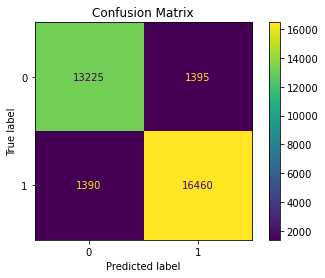

In [28]:
# Construct and display my confusion matrix.

# Construct the confusion matrix for the predicted and test values.

cm = confusion_matrix(y_test, y_pred, labels=xgb_cv.classes_)

# Create the display for the confusion matrix.

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)

# Plot the visual in-line.

disp.plot(values_format='')
plt.title('Confusion Matrix')
plt.show();

**Commentary:**

My FNs and FPs are relatively balanced, with a slightly higher number of FPs than FNs.  Also, the TPs have a higher proportion than the TNs, consistent with the overall dataset proportion that we calculated above.

### Visualize most important features

`xgboost` has a built-in function to visualize the relative importance of the features in the model using `matplotlib`. I will output and examine the feature importance of my XGBoost model.

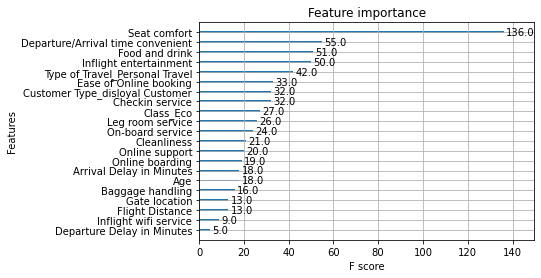

In [29]:
# Plot relative feature importance of the predictor variables in model by passing the best_estimator_ attribute.

plot_importance(xgb_cv.best_estimator_)

# XGBoost's default importance_type is "gain," which measures the average gain or loss reduction
# provided by a feature when it's used in a tree split.

**Commentary:**

The feature importance was markedly different from the Decision Tree and Random Forest models, which listed Inflight entertainment, Seat comfort, and Ease of Online Booking as the top three, respectively. For XGBoost, however, `Seat comfort` ranks first by a large margin, followed by `Departure/Arrival time convenient`, and then `Food and Drink`.

**Note:** The "F score" on the x-axis stands for "Frequency." It's a count of how many times a feature was chosen to split the model's trees. Some libraries use the term "gain" or "weight," rather than F score, in plotting feature importance.

### Compare models

Create a table of results to compare model performance.

In [30]:
# Create a table of results to compare model performance.

# Create a DataFrame of evaluation metrics for the previous models and the new XGB metrics.
table_of_results = pd.DataFrame({
    'Model': ['Tuned Decision Tree', 'Tuned Random Forest', 'Tuned XGBoost'],
    'F1': [0.945121, 0.944418, f1_score],
    'Recall': [0.933831, 0.943486, rc_score],
    'Precision': [0.956703, 0.945352, pc_score],
    'Accuracy': [0.940648, 0.939176, ac_score],
    'ROC AUC score': ['na', 'na', roc_auc_score]}
)

table_of_results         

,Model,F1,Recall,Precision,Accuracy,ROC AUC score
0,Tuned Decision Tree,0.945121,0.933831,0.956703,0.940648,na
1,Tuned Random Forest,0.944418,0.943486,0.945352,0.939176,na
2,Tuned XGBoost,0.922000,0.922129,0.921871,0.914229,0.913356


**Observation:** 

This XGBoost model did not perform as well as the other models, however, it was very close on most metrics and was only off by approximately 0.02, generally speaking. Across the board, the Tuned Decision Tree outperformed the other two models. It is possible that my hyperparameter search for the XGBoost model was not sufficiently exhaustive, by comparison to the decision tree and random forest models.

## Considerations

**Key takeaways I learned from this lab:**

- During training (i.e., fitting the model), XGBoost uses a prediction of the predecessor model's residual with each iteration to find the minimum of the loss function. The loss function quantifies the error between the model's predictions and the actual values. The purpose of this process is to find a set of the model's internal parameters (such as the split points in a decision tree) that results in the lowest possible value for the loss function. These internal parameters are distinct from hyperparameters, which control **how** the model training process occurs to find the best combination that produces a model with the best predictive power on unseen data.
- XGB has unique hyperparameters, such as n_estimators, learning_rate, colsample_bytree, and min_child_weight.
- Ideal use cases for XGBoost are high-dimensional data (i.e., many features), imbalanced data, and revealing hidden relationships.  For example, XGBoost revealed high feature importance for `Departure/Arrival time convenient`, and `Food and Drink`, which were not captured in the decision tree and random forest models.
- The ROC-AUC score to assess how well my false positive rate is performing in comparison to the true positive rate, because of the importance of reducing the risk of classifying a flyer as "satisfied," when in fact they are not, and therefore, more likely to churn.
- The F1 score assesses the balance between False Positives and False Negatives.

**How I would share my findings with my team?**

- Data visualization for the model's predictions by using a Confusion Matrix
- Summary tabular format for the compartive evaluation scores across the three models, highlighting the F1 scores.
- Data visualization for the feature importance comparisons.

**What I would share with and recommend to my stakeholders?**

- Metrics Results Table that compares the models and their evaluation scores
- In presenting the Feature Importance bar chart, I would recommend addressing and improving `Seat Comfort,` as it came it as more than double the next reported importance feature.
